In [1]:
import glob
import os

from astropy.time import Time
import astropy.units as u
import h5py
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd 
import scipy.stats as st
from sklearn.neighbors import KernelDensity

import huxt as H
import huxt_analysis as HA
import sir_huxt_lon as shl

mpl.rc("axes", labelsize=16)
mpl.rc("ytick", labelsize=16)
mpl.rc("xtick", labelsize=16)
mpl.rc("legend", fontsize=16)

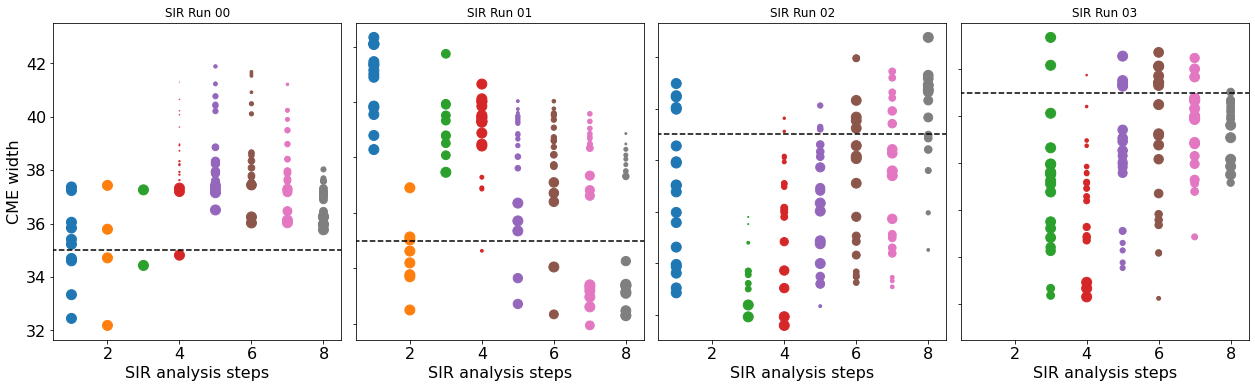

In [7]:
dirs = shl.get_project_dirs()
data_dir = os.path.join(dirs['sir_analysis'], "shw_calibrate", "SIR_HUXt_*.hdf5")
files = glob.glob(data_dir)

fig, ax = plt.subplots(1, 4, figsize=(20, 5))

for i in range(ax.size):
    
    out_file = h5py.File(files[i], 'r')

    wid_truth = np.rad2deg(out_file['truth_cme_params'][:][3])
    
    for j in range(8):

        key = "analysis_{:02d}".format(j)
        
        wid = out_file[key]['width'][:]
        weights = out_file[key]['weight'][:]
        sz = 100*(weights - np.min(weights)) / (np.max(weights) - np.min(weights))

        y = np.ones(wid.shape) + j
        ax[i].scatter(y, wid, s=sz, marker='o')
        ax[i].set_title('SIR Run {:02d}'.format(i))
        
    out_file.close()

        
for a in ax:
    a.hlines(wid_truth, 0, 9, linestyles=['--'], colors=['k'], label='True CME width')
    a.set_xlim(0.5, 8.5)
    #a.set_ylim(930,1070)
    a.set_xlabel('SIR analysis steps')

ax[0].set_ylabel('CME width')
    
for a in ax[1:]:
    a.set_yticklabels([])
    
fig.subplots_adjust(left=0.15, bottom=0.1, right=0.98, top=0.98, wspace=0.05, hspace=0.05)
#fig.savefig('parameter_vs_step_{:02d}.png'.format(j))

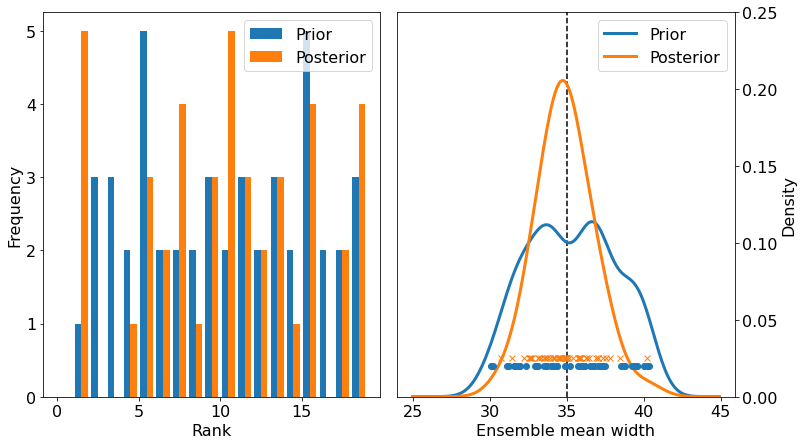

In [9]:
dirs = shl.get_project_dirs()
data_dir = os.path.join(dirs['sir_analysis'], "shw_calibrate", "SIR_HUXt_*.hdf5")
files = glob.glob(data_dir)

# Get ranks and ensemble means of the priors
wid_rank_prior = [] 
wid_avg_prior = []

ess_prior = []

key = "analysis_00"

for f in files: 

    out_file = h5py.File(f, 'r')
    
    cme_truth_params = out_file['truth_cme_params'][:]
    wid_truth = np.rad2deg(cme_truth_params[3])
    
    # Rank the truth amongst prior ensemble
    # Speed first
    wid = out_file[key]['width'][:]
    wid_all = np.append(wid, wid_truth)
    wid_ranks = st.rankdata(wid_all)
    wid_rank_prior.append(wid_ranks[-1])
    # Ensemble mean of prior
    wid_avg_prior.append(np.mean(wid))
    
    # Now get effective sample size
    w = out_file[key]['weight'][:]   
    ess = 1 / np.sum(w**2)
    ess_prior.append(ess)

    out_file.close()

    
# Get ranks and ensemble means of the priors
wid_rank_post = [] 
wid_avg_post = []

ess_post = []

key = "analysis_07"

for f in files: 

    out_file = h5py.File(f, 'r')
    
    cme_truth_params = out_file['truth_cme_params'][:]
    wid_truth = np.rad2deg(cme_truth_params[3])
    
    # Rank the truth amongst prior ensemble
    # Speed first
    wid = out_file[key]['width'][:]
    wid_all = np.append(wid, wid_truth)
    wid_ranks = st.rankdata(wid_all)
    wid_rank_post.append(wid_ranks[-1])
    # Ensemble mean of prior
    wid_avg_post.append(np.mean(wid))
     
    # Now get effective sample size
    w = out_file[key]['weight'][:]   
    ess = 1 / np.sum(w**2)
    ess_post.append(ess)

    out_file.close()
    
wid_avg_prior = np.array(wid_avg_prior)
wid_avg_post = np.array(wid_avg_post)
#############################################################
# Plot rank hist and kernel density of prior and posterior V
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

ax[0].hist([wid_rank_prior, wid_rank_post], bins=np.arange(0, len(wid)), label=['Prior', 'Posterior'])

cmap = plt.get_cmap("tab10")
for lon, col, label in zip([wid_avg_prior, wid_avg_post], [cmap(0), cmap(1)], ['Prior', 'Posterior']):
    
    kde = KernelDensity(kernel='gaussian', bandwidth=1).fit(lon.reshape(-1,1))
    wid_grid = np.arange(25, 45, 0.1)
    log_pdf = kde.score_samples(wid_grid.reshape(-1,1))
    pdf = np.exp(log_pdf)

    ax[1].plot(wid_grid, pdf, color=col, label=label, linewidth=3)
    
    
y = np.zeros(wid_avg_prior.shape) + 0.02    
ax[1].plot(wid_avg_prior, y, 'o', color=cmap(0))

y = np.zeros(wid_avg_post.shape) + 0.025    
ax[1].plot(wid_avg_post, y, 'x', color=cmap(1))


ax[1].vlines(wid_truth, 0, 0.3, linestyles=['--'], colors=['k'])
    
ax[1].yaxis.tick_right()
ax[1].yaxis.set_label_position("right")

ax[0].set_xlabel('Rank')
ax[0].set_ylabel('Frequency')
ax[0].legend()

ax[1].set_xlabel('Ensemble mean width')
ax[1].set_ylabel('Density')
ax[1].set_ylim(-0.0001, 0.25)
#ax[1].set_xlim(900, 1100)
ax[1].legend()

fig.subplots_adjust(left=0.1,bottom=0.1, right=0.9, top=0.99, wspace=0.05)